In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update('jax_enable_x64', True)

import pennylane as qml

symbols = ["H", "H"]
coordinates = np.array([[0.0, 0.0, -0.6614], [0.0, 0.0, 0.6614]])
molecule = qml.qchem.Molecule(symbols, coordinates)
H, qubits = qml.qchem.molecular_hamiltonian(molecule)
print("Number of qubits = ", qubits)
print("The Hamiltonian is ", H)

Number of qubits =  4
The Hamiltonian is  -0.042072551947440084 * I(0) + 0.1777135822909176 * Z(0) + 0.1777135822909176 * Z(1) + 0.17059759276836806 * (Z(0) @ Z(1)) + -0.24274501260941383 * Z(2) + 0.12293330449299354 * (Z(0) @ Z(2)) + 0.1676833885560135 * (Z(1) @ Z(2)) + 0.04475008406301996 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04475008406301996 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04475008406301996 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04475008406301996 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.24274501260941383 * Z(3) + 0.1676833885560135 * (Z(0) @ Z(3)) + 0.12293330449299354 * (Z(1) @ Z(3)) + 0.17627661394181787 * (Z(2) @ Z(3))


In [3]:
dev = qml.device("lightning.qubit", wires=qubits)

In [4]:
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
print(hf)

[1 1 0 0]


In [5]:
@qml.qnode(dev, interface="jax")
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])
    return qml.expval(H)

In [6]:
def cost_fn(param):
    return circuit(param, wires=range(qubits))

In [7]:
import optax

max_iterations = 100
conv_tol = 1e-06

opt = optax.sgd(learning_rate=0.4)

In [8]:
theta = np.array(0.)

# store the values of the cost function
energy = [cost_fn(theta)]

# store the values of the circuit parameter
angle = [theta]

# store the internal state of the optax optimizer
opt_state = opt.init(theta)

for n in range(max_iterations):

    gradient = jax.grad(cost_fn)(theta)
    updates, opt_state = opt.update(gradient, opt_state)
    theta = optax.apply_updates(theta, updates)

    angle.append(theta)
    energy.append(cost_fn(theta))

    conv = np.abs(energy[-1] - energy[-2])

    if n % 2 == 0:
        print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha,  Angle: {angle[-1]:.5f};")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.5f}")

Step = 0,  Energy = -1.12799983 Ha,  Angle: 0.07160;
Step = 2,  Energy = -1.13466246 Ha,  Angle: 0.15013;
Step = 4,  Energy = -1.13590595 Ha,  Angle: 0.18406;
Step = 6,  Energy = -1.13613667 Ha,  Angle: 0.19868;
Step = 8,  Energy = -1.13617944 Ha,  Angle: 0.20498;
Step = 10,  Energy = -1.13618736 Ha,  Angle: 0.20769;
Step = 12,  Energy = -1.13618883 Ha,  Angle: 0.20885;

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.20885


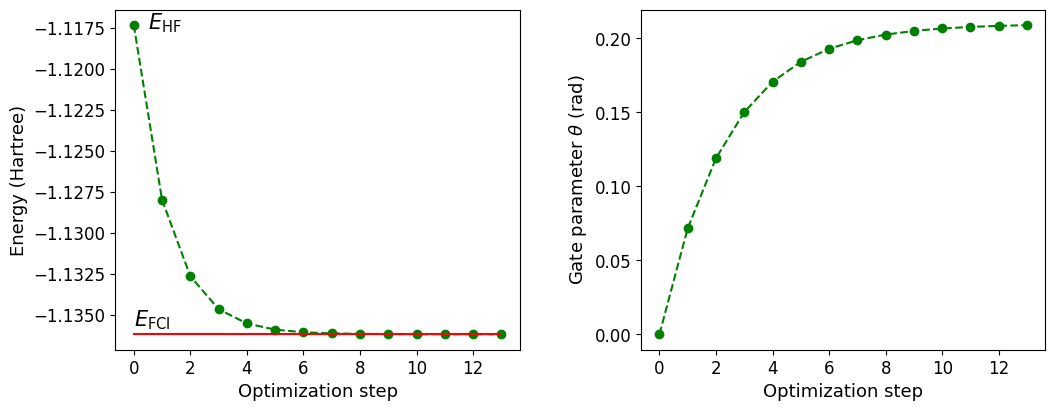

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Full configuration interaction (FCI) energy computed classically
E_fci = -1.136189454088

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(n + 2), energy, "go", ls="dashed")
ax1.plot(range(n + 2), np.full(n + 2, E_fci), color="red")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Energy (Hartree)", fontsize=13)
ax1.text(0.5, -1.1176, r"$E_\mathrm{HF}$", fontsize=15)
ax1.text(0, -1.1357, r"$E_\mathrm{FCI}$", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add angle plot on column 2
ax2 = fig.add_subplot(122)
ax2.plot(range(n + 2), angle, "go", ls="dashed")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.subplots_adjust(wspace=0.3, bottom=0.2)
plt.show()